In [10]:
%cd C:\Users\MooreLab

C:\Users\MooreLab


In [8]:
import numpy as np
import math
import sympy
import scipy
import matplotlib.pyplot as plt
from scipy import special
from sympy import *

In [12]:
confidence_matrix = np.load("new_conf_matrix.npy")
stim_pos = np.load("original_stim_pos.npy")

In [17]:
# Define some parameters
binsize_generative = 2*np.pi/8
binsize_fit        = 2*np.pi/100

# generate x values
theta_generative = np.arange(-np.pi, np.pi - binsize_generative, binsize_generative)
theta_fit = np.arange(-np.pi, np.pi - binsize_fit, binsize_fit)

theta_generative = np.append(theta_generative, 2.35619449)
theta_fit = np.append(theta_fit, 3.0787608100000003)

In [18]:
def cresultant(X, Y):
    R = sum(Y * np.exp(1j*X)) / sum(Y)
    return R 

In [19]:
def cmean(X, Y):
    M = np.angle(cresultant(X,Y))
    return M

In [20]:
mu_fit = cmean(theta_generative, confidence_matrix[124,365,:])
print(mu_fit)

0.785529297576096


In [21]:
def cstd(X, Y):
    R = np.abs(cresultant(X,Y))
    S = np.sqrt(-2 * np.log(R))
    return S

In [22]:
std_fit = cstd(theta_generative, confidence_matrix[124,365,:])
print(std_fit)

0.0202901993019945


In [23]:
def sd2k(S):
    R = np.exp((-np.power(S,2))/2)
    K = fastAlinv(R)
    return K 

In [29]:
kappa_fit = sd2k(std_fit)
print(kappa_fit)

[2429.49929888]


In [25]:
def fastAlinv(R):
    R = np.asarray(R)
    R = R.flatten()
    #print(R)
    length = len(R)
    K = np.zeros(length)
    
    index = np.where((R >= 0) & (R < 0.53))
    K[index] = 2 * R[index] + np.power(R[index],3) + ((5 * np.power(R[index], 5))/6)
    
    index = np.where((R >= 0.53) & (R < 0.85))
    K[index] = -0.4 + 1.39 * R[index] + np.divide(0.43, (1-R[index]))
    
    index = np.where((R >= 0.85) & (R <= 1))
    K[index] = np.divide(1, (np.power(R[index], 3) - 4 * np.power(R[index], 2) + 3 * R[index]))
    
    return K 

In [26]:
def besseliln(nu, z):
    w = np.log(scipy.special.ive(nu,z)) + np.abs(z.real)
#     print(w)
    return w 

In [27]:
def vonmisespdf(x, mu, k):
    p = np.exp(np.multiply(k, np.cos(x-mu)) - np.log(2*np.pi) - besseliln(0,k))
    return p

In [28]:
def peakConfidence(mu, k):
    peakConfidence_fit = vonmisespdf(mu, mu, k) * binsize_generative
    return peakConfidence_fit

In [30]:
peakConfidence_fit = peakConfidence(mu_fit, kappa_fit)
print(peakConfidence_fit)

[15.44315345]


In [31]:
# Using curve_fit
from scipy.optimize import curve_fit

In [38]:
confidence_matrix[124,365,:]

array([6.04378376e-05, 2.47750300e-07, 1.84212976e-08, 5.04514247e-07,
       1.31561578e-05, 9.99827149e-01, 1.00595360e-06, 9.74802147e-05])

In [37]:
stim_pos[124]

-2.35619449

In [134]:
# x = confidence_matrix[124,365,:]
# y = [stim_pos[124], stim_pos[124], stim_pos[124], stim_pos[124], stim_pos[124], stim_pos[124], stim_pos[124], stim_pos[124]]

x = [-2.35619449, -1.57079633, -0.78539816,  0, 
     0.78539816, 1.57079633, 2.35619449, 3.14159265]
y = confidence_matrix[100,40,:]

def objective(x, alpha, k, mu):
    return alpha * np.exp(k * np.cos(x-mu))

In [140]:
# popt, _ = curve_fit(objective, x, y, p0=[1, 2429, 0.786])
popt, _ = curve_fit(objective, x, y, p0=[1.32690438e-08, 30, -2.26853427e+00],
                    bounds=([0, 0, -np.pi], [50, 50, np.pi]))
# popt, _ = curve_fit(objective, x, y)
alpha, k, mu = popt
print(popt)

[ 1.32689289e-08  1.81630937e+01 -2.26853412e+00]


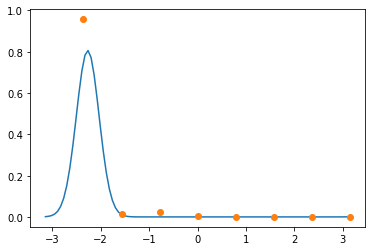

In [141]:
# Using Curve_fit     (mu, kappa)
# pdf_fit = vonmisespdf(theta_fit, mu, k)
pdf_fit = objective(theta_fit, alpha, k, mu)
pdf_fit = pdf_fit * binsize_generative
plt.plot(theta_fit,pdf_fit)
plt.plot(x, confidence_matrix[100,40,:], 'o')
plt.show()

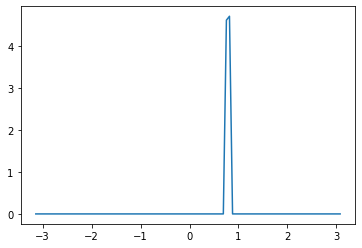

In [35]:
# Using vonmises on top  mu,kappa
pdf_fit = vonmisespdf(theta_fit, mu_fit, kappa_fit)
pdf_fit = pdf_fit * binsize_generative
plt.plot(theta_fit,pdf_fit)
plt.show()

In [ ]:
# PLAYGROUND

In [1]:
pip install lmfit

Note: you may need to restart the kernel to use updated packages.


In [4]:
def vonmises(x, alpha, k, mu):
    return alpha * np.exp(k * np.cos(x-mu))

In [59]:
from lmfit import Model

gmodel = Model(vonmises)
print(f'parameter names: {gmodel.param_names}')
print(f'independent variables: {gmodel.independent_vars}')

parameter names: ['alpha', 'k', 'mu']
independent variables: ['x']


In [60]:
params = gmodel.make_params(alpha=1, k=1, mu=1)

In [61]:
x = [-2.35619449, -1.57079633, -0.78539816,  0, 
     0.78539816, 1.57079633, 2.35619449, 3.14159265]
y = confidence_matrix[124,365,:]
# x = confidence_matrix[124,365,:]
# y = [stim_pos[124], stim_pos[124], stim_pos[124], stim_pos[124], stim_pos[124], stim_pos[124], stim_pos[124], stim_pos[124]]

In [62]:
result = gmodel.fit(y, params, x=x)

In [63]:
result.fit_report()

'[[Model]]\n    Model(vonmises)\n[[Fit Statistics]]\n    # fitting method   = leastsq\n    # function evals   = 8000\n    # data points      = 8\n    # variables        = 3\n    chi-square         = 2.1063e-08\n    reduced chi-square = 4.2126e-09\n    Akaike info crit   = -152.041551\n    Bayesian info crit = -151.803227\n##  Warning: uncertainties could not be estimated:\n[[Variables]]\n    alpha:  6.4502e-15 (init = 1)\n    k:      32.6745531 (init = 1)\n    mu:     1.56882668 (init = 1)'

In [ ]:
alpha:  6.4502e-15 (init = 1)
k:      32.6745531 (init = 1)   
mu:     1.56882668 (init = 1)

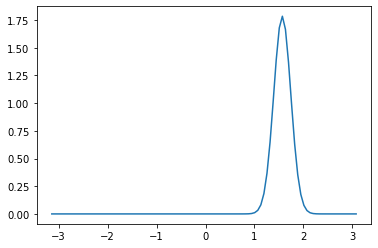

In [64]:
# Using lmfit
pdf_fit = vonmises()
pdf_fit = pdf_fit * binsize_generative
plt.plot(theta_fit,pdf_fit)
plt.show()